In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv('../input/train_V2.csv')

In [3]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
test =  pd.read_csv('../input/test_V2.csv')

In [5]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,0,0,0,0.00,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,0,2,1,361.90,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,0,0,0,0.00,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,0,0,0,0.00,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,0,3,1,60.06,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [6]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [7]:
train.drop(2744604, inplace=True)

In [8]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp
from plotnine import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

# Machine Learning
import sklearn
from sklearn import metrics
from scipy.cluster import hierarchy as hc
from fastai.imports import *
from fastai.structured import *
# For notebook plotting
%matplotlib inline

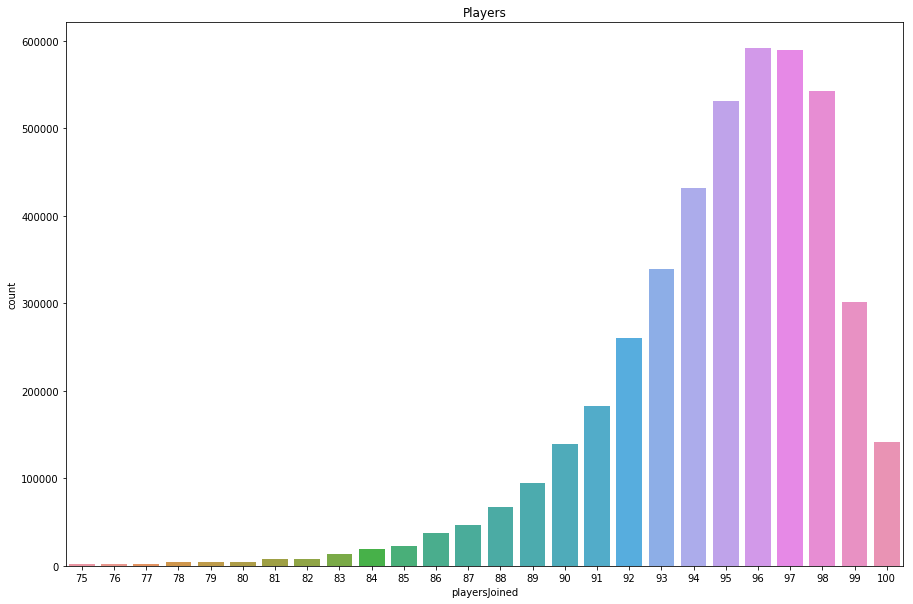

In [9]:
# playersJoined
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
plt.title('Players')
plt.show()

In [10]:
# Create normalized features
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100 + 1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


In [11]:
# Create new feature healsandboosts
train['healsandboosts'] = train['heals'] + train['boosts']
train[['heals', 'boosts', 'healsandboosts']].tail()

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


In [12]:
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

In [13]:
# Create headshot_rate feature
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

In [14]:
display(train[train['killsWithoutMoving'] == True].shape)
train[train['killsWithoutMoving'] == True].head(10)

(1535, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.00,0,0,3,18,0,6,3,23.540,593,normal-squad-fpp,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,58,8.52,842.0600,21.30,842.06,3,0.0,True,0.000000
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.60,0,0,6,33,0,3,1,6.523,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000,42,4.74,547.6280,17.38,2834.52,6,0.0,True,0.000000
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.00,0,4,5,3,0,20,6,37.080,898,normal-solo-fpp,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947,21,35.80,3132.5000,35.80,1607.42,5,0.0,True,0.200000
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.80,0,0,0,69,1000,1,1,21.540,799,normal-squad-fpp,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000,73,1.27,200.4060,24.13,1014.73,0,0.0,True,0.000000
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.00,0,1,0,37,0,1,1,55.430,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000,42,1.58,158.0000,17.38,2834.52,0,0.0,True,1.000000
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.10,4,1,3,7,0,6,2,81.920,583,normal-squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8000,44,9.36,789.5160,9.36,909.48,3,0.0,True,0.166667
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.00,0,4,1,7,0,12,5,116.300,550,normal-squad-fpp,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.6000,48,18.24,1708.4800,9.12,836.00,1,0.0,True,0.333333
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.90,0,2,11,12,0,7,2,84.370,599,normal-squad-fpp,15,15,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,57,10.01,757.7570,21.45,856.57,11,0.0,True,0.285714
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.90,0,1,6,53,1000,2,1,26.990,732,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,0,0,0.0,12,1500,0.2857,61,2.78,179.1710,11.12,1017.48,7,0.0,True,0.500000
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.56,0,0,0,46,0,1,1,16.440,715,normal-squad-fpp,15,14,1500,0,0.0,0,0.0,0,0,0.0,4,0,0.8571,53,1.47,125.7732,22.05,1051.05,0,0.0,True,0.000000


In [15]:
# Remove outliers
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

In [16]:
# Players who got more than 10 roadKills
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.0,0,1371,0.4286,92,15.12,1345.68,99.36,1572.48,0,1282.302,False,0.000000
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.6,5,1533,0.4713,88,12.32,1234.24,98.56,2179.52,0,4934.600,False,0.000000
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.0,4,1568,1.0000,38,32.40,3359.88,61.56,3191.40,19,5876.000,False,0.050000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.400,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.0,10,1606,0.9398,84,20.88,2164.56,97.44,2233.00,10,7853.000,False,0.277778


In [17]:
train.drop(train[train['roadKills'] > 10].index, inplace=True)

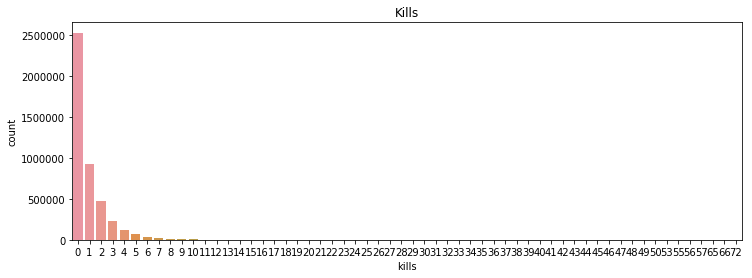

In [18]:
plt.figure(figsize=(12,4))
sns.countplot(data=train, x=train['kills']).set_title('Kills')
plt.show()

In [19]:
# Players who got more than 30 kills
display(train[train['kills'] > 30].shape)
train[train['kills'] > 30].head(10)

(95, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3725.0,0,7,0,2,1000,35,3,105.80,1798,normal-duo-fpp,8,7,-1,0,0.0,0,0.0,0,0,48.82,48,1500,0.8571,16,64.40,6854.00,14.72,3308.32,0,48.82,False,0.200000
87793,45f76442384931,b3627758941d34,37f05e2a01015f,8,0,3087.0,0,8,27,3,1000,31,3,95.34,1798,normal-duo-fpp,8,7,-1,0,0.0,0,0.0,0,0,780.70,45,1500,1.0000,16,57.04,5680.08,14.72,3308.32,27,780.70,False,0.258065
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.95,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,23.71,61,0,0.7000,11,90.72,10355.31,20.79,3398.22,7,23.71,False,0.250000
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,1000,42,5,266.20,844,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,1,0,718.30,16,1500,1.0000,62,57.96,5565.54,11.04,1164.72,0,718.30,False,0.952381
180189,1355613d43e2d0,f863cd38c61dbf,39c442628f5df5,5,0,3171.0,0,6,15,1,0,35,3,102.50,1796,normal-solo-fpp,9,6,1500,0,0.0,0,0.0,0,0,71.51,41,0,1.0000,11,66.15,5993.19,17.01,3394.44,15,71.51,False,0.171429
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,0,65,7,73.90,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,1036.00,60,0,1.0000,11,122.85,12504.24,20.79,3398.22,5,1036.00,False,0.200000
353128,f3e9746e3ff151,4bc1f00f07b304,a9e84c456cc859,2,0,3834.0,0,9,5,1,0,39,3,263.90,1795,normal-solo-fpp,13,10,1500,0,0.0,0,0.0,0,0,124.20,42,0,1.0000,13,72.93,7169.58,24.31,3356.65,5,124.20,False,0.230769
457829,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2907.0,0,27,2,1,0,33,4,439.20,827,normal-squad,5,5,1500,0,0.0,0,0.0,1,0,382.40,15,0,1.0000,38,53.46,4709.34,8.10,1339.74,2,382.40,False,0.818182
488335,31a0682922ef45,275a27a3ee4cc8,3037f74ef8a3a3,2,0,3055.0,0,9,0,1,1000,33,5,97.99,892,normal-solo-fpp,18,14,-1,0,0.0,0,0.0,0,0,35.30,31,1500,1.0000,20,59.40,5499.00,32.40,1605.60,0,35.30,False,0.272727
662650,dd424a8b74bd49,ac9dea6d62f2e6,8a728def0644be,9,0,3454.0,38,9,4,1,1000,34,4,124.00,1198,normal-squad-fpp,14,14,-1,0,0.0,0,0.0,0,0,111.10,25,1500,0.2308,54,49.64,5042.84,20.44,1749.08,4,111.10,False,0.264706


In [20]:
train.drop(train[train['kills'] > 30].index, inplace=True)

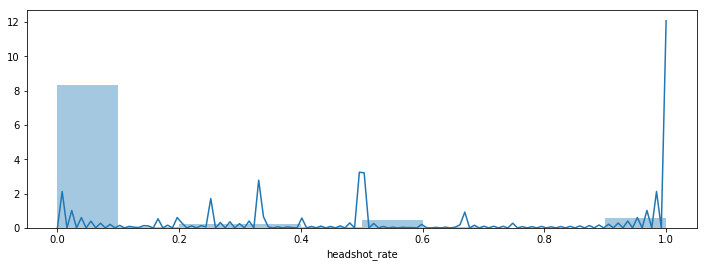

In [21]:
plt.figure(figsize=(12,4))
sns.distplot(train['headshot_rate'], bins=10)
plt.show()

In [22]:
# Players who made a minimum of 10 kills and have a headshot_rate of 100%
display(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].head(10)

(24, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.20,1423,squad-fpp,27,25,1564,1,0.0,0,0.0,0,0,2939.0,5,0,0.8462,93,10.70,1296.84,28.89,1522.61,3,2939.0,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.60,1727,squad,27,26,-1,3,4720.0,0,0.0,0,0,3422.0,8,1560,1.0000,96,11.44,1684.80,28.08,1796.08,8,8142.0,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.80,1255,squad,27,27,-1,0,0.0,0,0.0,0,0,2105.0,5,1587,1.0000,98,13.26,1392.30,27.54,1280.10,4,2105.0,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.20,1838,squad-fpp,28,24,-1,0,5187.0,0,0.0,2,0,2761.0,7,1519,0.9630,95,10.50,1611.75,29.40,1929.90,8,7948.0,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.00,1417,squad,27,26,-1,0,1018.0,0,0.0,0,0,2458.0,4,1562,1.0000,96,10.40,1409.20,28.08,1473.68,8,3476.0,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,484.90,1821,squad-fpp,28,27,1495,0,5246.0,0,0.0,0,0,2932.0,4,0,1.0000,95,11.55,1278.90,29.40,1912.05,8,8178.0,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.00,1246,squad-fpp,27,27,-1,0,408.9,0,0.0,0,0,2450.0,7,1468,1.0000,97,10.30,1096.95,27.81,1283.38,5,2858.9,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.00,1730,squad-fpp,28,28,1560,0,2048.0,0,0.0,0,0,3915.0,5,0,1.0000,93,12.84,1411.33,29.96,1851.10,6,5963.0,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.60,1248,duo,46,41,0,1,0.0,0,0.0,0,0,3108.0,7,1500,1.0000,88,12.32,1288.00,51.52,1397.76,5,3108.0,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.14,1379,duo-fpp,49,48,1813,0,0.0,0,140.8,0,0,2339.0,4,0,1.0000,96,13.52,1537.12,50.96,1434.16,12,2479.8,False,1.0


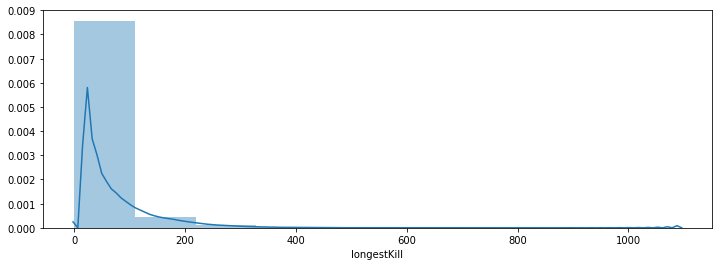

In [23]:
plt.figure(figsize=(12,4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

In [24]:
display(train[train['longestKill'] >= 1000].shape)
train[train['longestKill'] >= 1000].head(10)

(20, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.9,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.2,0,0.0,0,1,3052.00,9,0,0.9231,88,4.48,877.968,30.24,2087.68,4,3775.20,False,0.250000
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.0,8,5,7,18,1000,11,2,1004.0,1308,normal-duo-fpp,14,13,-1,1,0.0,0,0.0,0,0,48.87,38,1500,0.5385,29,18.81,2195.640,23.94,2236.68,7,48.87,False,0.454545
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.0,0,0,0,9,0,10,2,1026.0,698,normal-squad-fpp,13,13,1500,0,1717.0,0,0.0,0,0,1264.00,26,0,1.0000,51,14.90,1531.720,19.37,1040.02,0,2981.00,False,0.000000
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.0,17,5,0,3,1000,16,4,1000.0,1091,normal-squad-fpp,6,6,-1,4,0.0,0,0.0,0,0,29.21,30,1500,0.6000,41,25.44,2241.900,9.54,1734.69,0,29.21,False,0.312500
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.8,0,0,0,51,0,1,1,1075.0,471,normal-squad-fpp,8,8,1500,0,2085.0,0,0.0,0,0,1074.00,22,0,0.0000,61,1.39,273.552,11.12,654.69,0,3159.00,False,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.0,11,5,0,5,0,10,3,1094.0,1021,normal-squad-fpp,12,12,1500,0,0.0,0,0.0,0,0,569.50,18,0,0.9091,86,11.40,1153.680,13.68,1163.94,0,569.50,False,0.500000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.3,0,0,2,45,1000,3,1,1037.0,581,normal-squad-fpp,8,7,-1,0,0.0,0,0.0,0,0,832.50,9,1500,0.2857,58,4.26,467.606,11.36,825.02,3,832.50,False,0.000000
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.0,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.0,0,0.0,0,0,2848.00,4,1500,0.9412,52,22.20,2427.200,76.96,1827.80,6,2848.00,False,0.466667
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.0,0,4,11,11,0,23,2,1005.0,1798,normal-duo-fpp,15,12,1500,0,0.0,0,0.0,0,0,235.30,41,0,0.5000,28,39.56,3617.160,25.80,3092.56,13,235.30,False,0.173913
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.0,0,6,5,15,0,11,2,1037.0,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,133.20,43,0,0.6000,42,17.38,2057.160,17.38,2834.52,8,133.20,False,0.545455


In [25]:
# Remove outliers
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

In [26]:
train[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.445311e+06,4.445311e+06,4.445311e+06,4.445311e+06
mean,1.154628e+03,6.063272e+02,4.510977e+00,1.765466e+03
std,1.183514e+03,1.498567e+03,3.050773e+01,2.183257e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.606500e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


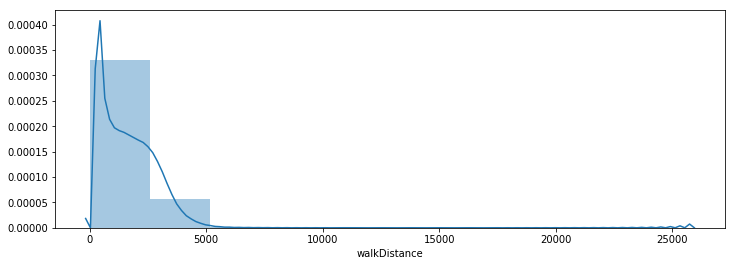

In [27]:
plt.figure(figsize=(12,4))
sns.distplot(train['walkDistance'], bins=10)
plt.show()

In [28]:
# walkDistance anomalies
display(train[train['walkDistance'] >= 10000].shape)
train[train['walkDistance'] >= 10000].head(10)

(219, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.00,0,0,0,44,0,0,0,0.000,1906,solo,99,93,1517,0,0.4212,0,9.882,0,0,13530.0,7,0,0.8163,99,0.00,0.0000,99.99,1925.06,1,13540.3032,False,0.0
34344,5a591ecc957393,6717370b51c247,a15d93e7165b05,0,3,23.22,0,0,1,34,1256,0,0,0.000,1977,squad-fpp,20,20,-1,0,0.0373,0,40.870,0,0,10030.0,7,1533,0.9474,65,0.00,31.3470,27.00,2668.95,4,10070.9073,False,0.0
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.20,1,0,1,24,0,1,1,6.823,2192,duo-fpp,47,46,1507,0,0.0088,0,36.750,0,0,12410.0,3,0,0.9130,94,1.06,124.2320,49.82,2323.52,5,12446.7588,False,0.0
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.34,0,0,1,46,1378,0,0,0.000,1836,duo-fpp,49,47,-1,0,847.8000,0,45.820,0,0,11590.0,3,1563,0.8333,96,0.00,33.6336,50.96,1909.44,2,12483.6200,False,0.0
94400,d441bebd01db61,7e179b3366adb8,923b57b8b834cc,1,1,73.08,0,0,3,27,1000,0,0,0.000,1806,solo,73,64,-1,0,1005.0000,0,45.630,0,0,10440.0,6,1488,0.8194,73,0.00,92.8116,92.71,2293.62,4,11490.6300,False,0.0
125103,db5a0cdc969dcb,50cc466757950e,c306a9745c4c1d,0,4,37.73,0,0,7,47,1000,0,0,0.000,1957,solo,95,93,-1,0,0.0378,0,38.760,0,0,12790.0,5,1500,0.7340,95,0.00,39.6165,99.75,2054.85,11,12828.7978,False,0.0
136421,955e60b09a96b1,30df08fe22a901,8669d01725f135,0,1,0.00,0,0,1,46,0,0,0,0.000,1973,duo-fpp,47,43,1590,0,1823.0000,0,30.810,0,0,10370.0,3,0,0.6957,94,0.00,0.0000,49.82,2091.38,2,12223.8100,False,0.0
136476,0d75d05b5c988c,3da040ce77cd0b,65bc5211a569dd,0,3,0.00,0,0,0,41,1370,0,0,0.000,1861,solo-fpp,91,89,-1,0,4581.0000,0,197.200,0,0,10140.0,5,1772,0.9333,91,0.00,0.0000,99.19,2028.49,3,14918.2000,False,0.0
154080,7e8a71d23381cd,e2c9f4f92840b2,a721de1aa05408,0,3,0.00,0,0,13,46,0,0,0,0.000,1923,solo-fpp,94,89,1476,0,2400.0000,0,16.700,0,0,10220.0,4,0,0.8602,94,0.00,0.0000,99.64,2038.38,16,12636.7000,False,0.0
154128,32fdde4c716787,390ae9a51c11b8,82610ed1b4d033,0,4,52.16,0,0,7,25,0,1,1,28.310,1836,duo-fpp,48,47,1451,1,0.0314,0,29.830,0,0,10860.0,6,0,0.8936,95,1.05,54.7680,50.40,1927.80,11,10889.8614,False,0.0


In [29]:
# Remove outliers
train.drop(train[train['walkDistance'] >= 10000].index, inplace=True)

In [30]:
display(train[train['rideDistance'] >= 20000].shape)
train[train['rideDistance'] >= 20000].head(10)

(150, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
28588,6260f7c49dc16f,b24589f02eedd7,6ebea3b4f55b4a,0,0,99.20,0,0,1,30,0,1,1,5.419,1894,solo,96,89,1642,0,25930.0,0,0.0,0,0,376.60,6,0,0.6421,96,1.04,103.1680,99.84,1969.76,1,26306.60,False,0.000000
63015,adb7dae4d0c10a,8ede98a241f30a,8b36eac66378e4,0,0,0.00,0,0,0,55,0,0,0,0.000,1891,solo,94,88,1529,0,21880.0,0,0.0,0,0,185.40,0,0,0.5376,94,0.00,0.0000,99.64,2004.46,0,22065.40,False,0.000000
70507,ca6fa339064d67,f7bb2e30c3461f,3bfd8d66edbeff,0,0,100.00,0,0,0,26,0,1,1,3.924,1928,solo,99,95,1512,0,28450.0,1,0.0,0,0,467.50,3,0,0.8878,99,1.01,101.0000,99.99,1947.28,0,28917.50,False,0.000000
72763,198e5894e68ff4,ccf47c82abb11f,d92bf8e696b61d,0,0,0.00,0,0,0,46,0,0,0,0.000,1807,solo-fpp,97,92,1534,0,20510.0,0,0.0,1,0,687.20,9,0,0.7917,97,0.00,0.0000,99.91,1861.21,0,21197.20,False,0.000000
95276,c3fabfce7589ae,15529e25aa4a74,d055504340e5f4,0,7,778.20,0,1,2,2,0,7,2,162.400,1874,solo,94,88,1495,0,25810.0,2,0.0,0,0,923.20,6,0,0.9785,94,7.42,824.8920,99.64,1986.44,9,26733.20,False,0.142857
140097,9944fbbea2b91e,18b4d5f4bb1906,d9d4a3e50cae75,1,0,12.55,0,0,0,53,1270,0,0,0.000,1899,solo-fpp,89,88,-1,0,21230.0,0,0.0,0,0,63.23,0,1514,0.5000,89,0.00,13.9305,98.79,2107.89,0,21293.23,False,0.000000
297186,88904c200175b6,012a61a01e146e,7a270c25e9b70c,0,1,0.00,0,0,1,47,0,0,0,0.000,1919,duo-fpp,48,47,1522,1,28970.0,0,0.0,0,0,297.30,3,0,0.7447,96,0.00,0.0000,49.92,1995.76,2,29267.30,False,0.000000
371098,f7071357f6b762,f3ee20821f4627,ac47c86bf385bf,0,0,72.92,1,0,0,45,0,0,0,0.000,1878,duo-fpp,49,46,1502,0,21700.0,0,0.0,0,0,242.10,4,0,0.6875,96,0.00,75.8368,50.96,1953.12,0,21942.10,False,0.000000
403647,c65da7b3fceef5,814d1b3736e276,ff9f570b555d48,0,2,0.00,0,0,3,54,0,0,0,0.000,1821,duo-fpp,47,46,1527,0,20600.0,0,0.0,0,0,598.20,1,0,0.6739,94,0.00,0.0000,49.82,1930.26,5,21198.20,False,0.000000
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.00,0,0,2,43,1120,0,0,0.000,2007,solo,83,83,-1,0,31960.0,0,0.0,0,0,402.10,3,1449,0.8171,83,0.00,0.0000,97.11,2348.19,4,32362.10,False,0.000000


In [31]:
# Remove outliers
train.drop(train[train['rideDistance'] >= 20000].index, inplace=True)

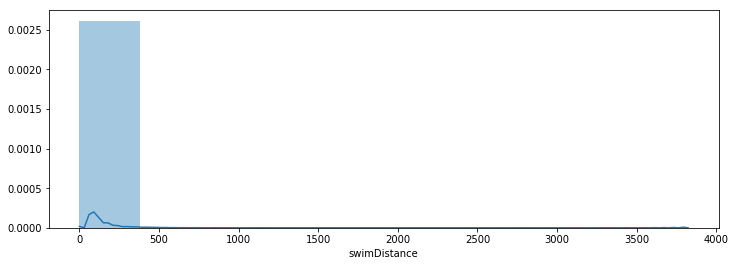

In [32]:
plt.figure(figsize=(12,4))
sns.distplot(train['swimDistance'], bins=10)
plt.show()

In [33]:
train[train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.12,1,0,1,47,1058,0,0,0.00,1399,duo-fpp,50,46,-1,0,0.0,0,2295.0,0,0,1002.000,4,1466,0.9592,98,0.00,79.6824,51.00,1426.98,6,3297.000,False,0.000000
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.32,0,0,16,39,0,0,0,0.00,2188,squad,26,25,1584,0,5689.0,0,2148.0,0,0,2276.000,5,0,0.9600,94,0.00,56.5192,27.56,2319.28,20,10113.000,False,0.000000
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.00,4,3,1,6,1103,3,1,868.70,1897,squad,26,25,-1,0,3331.0,0,2718.0,0,0,4691.000,5,1516,1.0000,88,3.36,563.3600,29.12,2124.64,2,10740.000,False,1.000000
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.30,3,1,6,4,1039,5,1,64.48,1396,duo-fpp,49,48,-1,0,0.0,0,2668.0,0,0,415.100,10,1499,1.0000,98,5.10,359.3460,49.98,1423.92,13,3083.100,False,0.200000
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.20,3,1,1,46,0,2,1,48.21,1021,normal-squad-fpp,12,12,1500,0,0.0,0,3823.0,0,0,995.300,9,0,1.0000,86,2.28,671.6880,13.68,1163.94,2,4818.300,False,0.500000
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.00,0,0,0,47,0,0,0,0.00,1387,squad-fpp,25,23,1327,0,864.0,0,2484.0,0,0,1966.000,3,0,0.5833,87,0.00,0.0000,28.25,1567.31,0,5314.000,False,0.000000
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.59,0,0,5,48,1097,0,0,0.00,1379,duo-fpp,48,46,0,1,2089.0,0,3514.0,0,0,4296.000,8,1492,0.8511,96,0.00,51.5736,49.92,1434.16,8,9899.000,False,0.000000
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.40,2,0,0,7,0,3,2,30.02,1210,squad-fpp,27,24,1516,0,0.0,0,2387.0,0,0,7.546,6,0,1.0000,91,3.27,517.0960,29.43,1318.90,1,2394.546,False,0.000000
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.80,5,5,2,2,0,7,1,696.80,2188,squad,26,25,1628,1,3033.0,0,2206.0,0,0,4687.000,4,0,0.9600,94,7.42,894.4280,27.56,2319.28,6,9926.000,False,0.714286
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.00,0,0,0,77,1056,0,0,0.00,1372,squad-fpp,29,29,-1,0,0.0,0,2338.0,0,0,1750.000,0,1518,0.2143,96,0.00,0.0000,30.16,1426.88,0,4088.000,False,0.000000


In [34]:
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

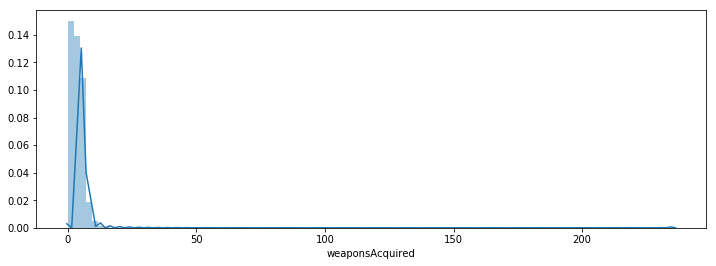

In [35]:
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [36]:
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(19, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.11,0,0,0,44,1279,0,0,0.0,1901,duo,46,45,-1,0,1880.0,0,0.00,0,0,1307.0,128,1577,0.7111,91,0.00,73.1499,50.14,2072.09,0,3187.00,False,0.000000
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.30,1,0,2,48,0,0,0,0.0,1372,squad,29,29,1473,0,0.0,0,0.00,0,0,1687.0,80,0,0.7500,98,0.00,178.8060,29.58,1399.44,3,1687.00,False,0.000000
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.00,0,0,0,24,0,1,1,110.6,1840,squad-fpp,29,28,1528,0,2852.0,0,47.21,0,0,2400.0,102,0,0.8929,97,1.03,103.0000,29.87,1895.20,0,5299.21,False,0.000000
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.00,0,0,0,54,0,0,0,0.0,1330,squad-fpp,26,23,1442,0,0.0,0,0.00,0,0,653.1,95,0,0.5600,80,0.00,0.0000,31.20,1596.00,0,653.10,False,0.000000
1592744,634a224c53444e,75fa7591d1538c,f900de1ec39fa5,9,0,1726.00,0,3,0,9,0,23,2,48.4,1798,normal-solo-fpp,11,11,1500,0,1908.0,0,0.00,0,0,980.8,94,0,0.2000,11,43.47,3262.1400,20.79,3398.22,0,2888.80,False,0.130435


In [37]:
# Remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

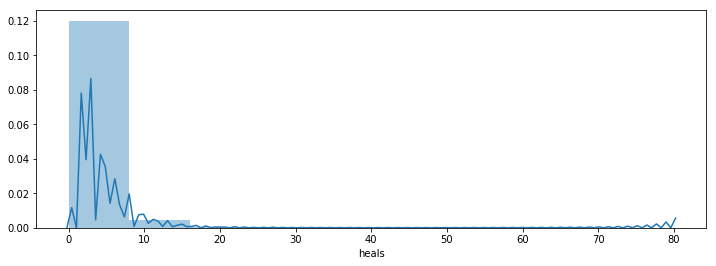

In [38]:
plt.figure(figsize=(12,4))
sns.distplot(train['heals'], bins=10)
plt.show()

In [39]:
# 40 or more healing items used
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(135, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,0,0,0,0.000,1797,solo-fpp,96,92,1527,0,5467.0,0,0.000,0,0,1387.0,6,0,0.9368,96,0.00,0.00,99.84,1868.88,49,6854.000,False,0.000000
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,0,1,1,5.515,1532,squad,27,27,1500,0,0.0,0,292.400,0,0,2791.0,7,0,0.9615,93,1.07,194.74,28.89,1639.24,47,3083.400,False,1.000000
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,1331,0,0,0.000,1374,solo-fpp,97,96,-1,0,0.0,0,3.443,0,0,1340.0,3,1543,0.8333,97,0.00,0.00,99.91,1415.22,54,1343.443,False,0.000000
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,0,0,0,0.000,1769,solo-fpp,97,94,1563,0,5934.0,0,0.000,0,0,1510.0,6,0,0.8646,97,0.00,0.00,99.91,1822.07,52,7444.000,False,0.000000
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,0,0,0,0.000,1878,solo-fpp,93,93,1500,0,3848.0,0,0.000,0,0,1968.0,9,0,0.8370,93,0.00,0.00,99.51,2009.46,53,5816.000,False,0.000000
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,1359,0,0,0.000,1295,squad-fpp,28,28,-1,0,0.0,0,0.000,0,0,2439.0,2,1511,0.9259,97,0.00,0.00,28.84,1333.85,44,2439.000,False,0.000000
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,0,0,0,0.000,1965,squad-fpp,30,29,1506,0,2596.0,0,0.000,0,0,2252.0,8,0,0.8276,99,0.00,124.23,30.30,1984.65,43,4848.000,False,0.000000
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,1254,1,1,33.310,1358,squad-fpp,32,31,-1,0,487.6,0,0.000,0,0,2928.0,3,1562,0.9355,95,1.05,183.75,33.60,1425.90,53,3415.600,False,1.000000
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,1000,27,3,87.190,1797,normal-solo-fpp,37,22,-1,0,0.0,0,0.000,0,0,268.8,33,1500,0.8889,41,42.93,3733.32,58.83,2857.23,41,268.800,False,0.296296
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,1034,4,2,35.420,1807,squad,28,25,-1,1,2438.0,0,0.000,0,0,2489.0,6,1517,0.9630,94,4.24,295.21,29.68,1915.42,51,4927.000,False,0.250000


In [40]:
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)

In [41]:
print('There are {} different Match types in the dataset.'.format(train['matchType'].nunique()))

There are 16 different Match types in the dataset.


In [42]:
# One hot encode matchType
train = pd.get_dummies(train, columns=['matchType'])

# Take a look at the encoding
matchType_encoding = train.filter(regex='matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [43]:
# Turn groupId and match Id into categorical types
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

# Get category coding for groupId and matchID
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

# Get rid of old columns
train.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613591,30085
1,827582,32751
2,843273,3143
3,1340072,45260
4,1757338,20531


In [44]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
train.drop(columns = ['Id'], inplace=True)

In [45]:
# Take sample for debugging and exploration
sample = 500000
df_sample = train.sample(sample)

In [46]:
# Split sample into training data and target variable
df = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [47]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 51) Sample target shape:  (440000,) Sample validation shape:  (60000, 51)


In [48]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
# This is the metric used by Kaggle in this competition
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [49]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.03928649564775994, 'mae val: ', 0.0623239839224124]


In [50]:
# What are the most predictive features according to our basic random forest model
fi = rf_feat_importance(m1, df); fi[:10]

,cols,imp
21,walkDistance,0.235108
6,killPlace,0.178322
30,totalDistance,0.175499
22,weaponsAcquired,0.080548
29,healsandboosts,0.072504
1,boosts,0.036708
10,longestKill,0.031603
5,heals,0.027287
2,damageDealt,0.024179
16,rideDistance,0.017269


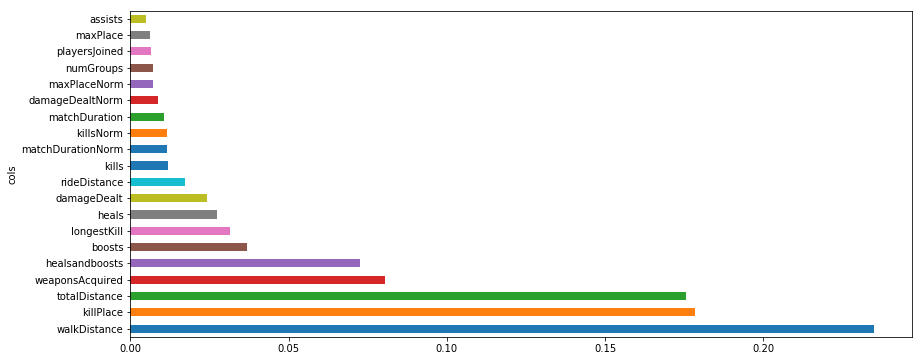

In [51]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:20].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

# Use this code if you want to save the figure
#fig = plot1.get_figure()
#fig.savefig("Feature_importances(AllFeatures).png")

In [52]:
#Keep only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  19


21         walkDistance
6             killPlace
30        totalDistance
22      weaponsAcquired
29       healsandboosts
1                boosts
10          longestKill
5                 heals
2           damageDealt
16         rideDistance
8                 kills
28    matchDurationNorm
25            killsNorm
11        matchDuration
26      damageDealtNorm
27         maxPlaceNorm
13            numGroups
24        playersJoined
12             maxPlace
Name: cols, dtype: object

In [53]:
# Make a DataFrame with only significant features
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [54]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train: ', 0.03681106117883714, 'mae val: ', 0.059767095671825275]


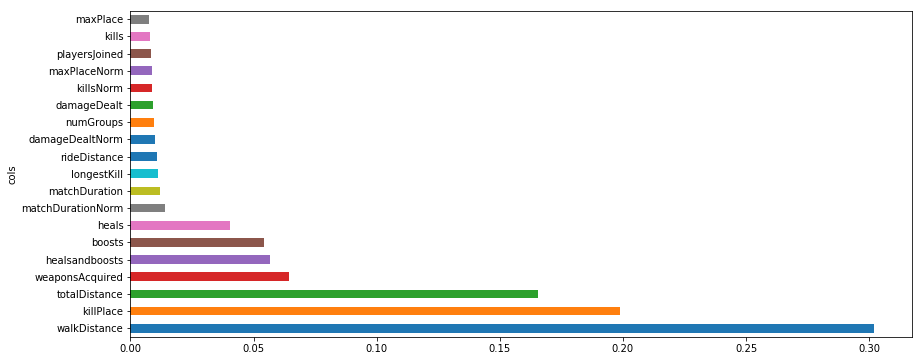

In [55]:
# Get feature importances of our top features
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

# Use this code if you want to save the figure
#fig = plot2.get_figure()
#fig.savefig("Feature_importances(TopFeatures).png")

[]

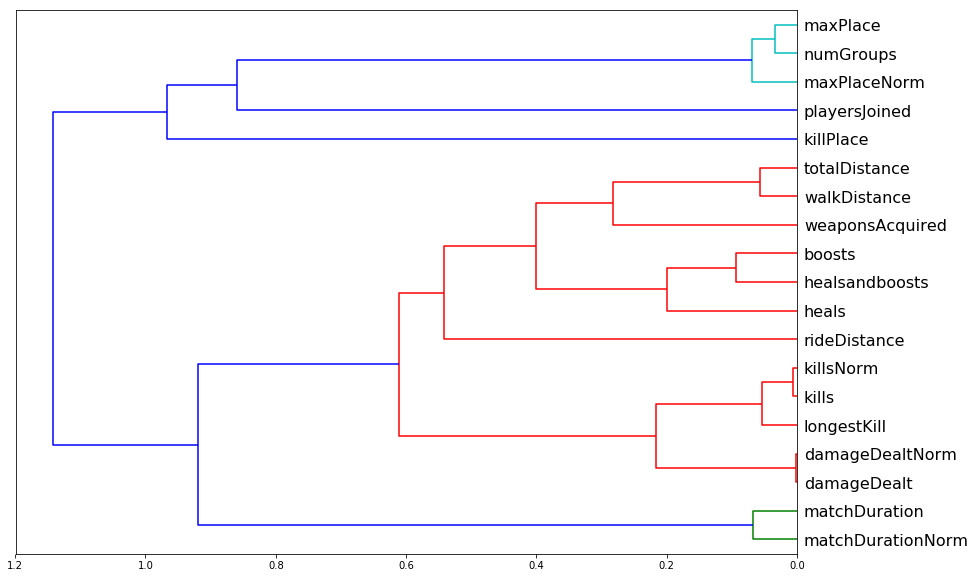

In [56]:
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.plot()

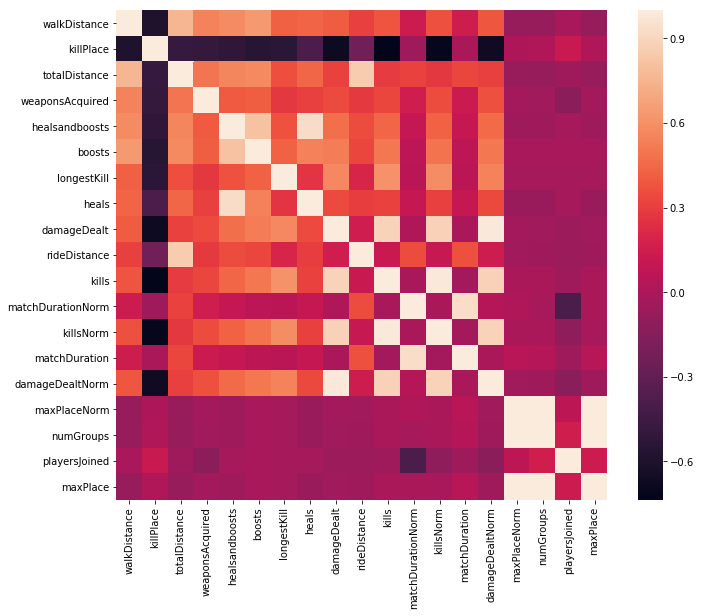

In [57]:
# Correlation heatmap
corr = df_keep.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Create heatmap
heatmap = sns.heatmap(corr)

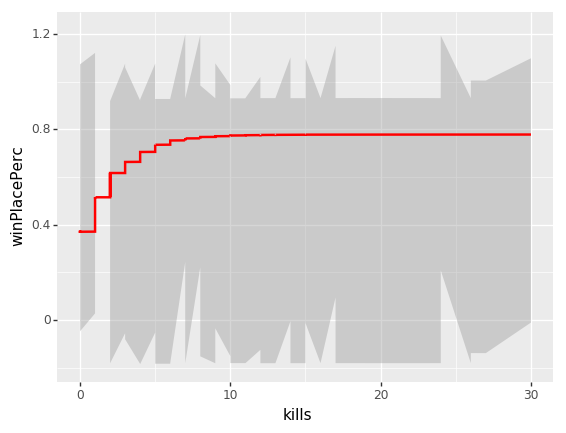

<ggplot: (-9223363301222227789)>

In [58]:
# Plot the predictive quality of kills 
x_all = get_sample(train, 100000)
ggplot(x_all, aes('kills','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

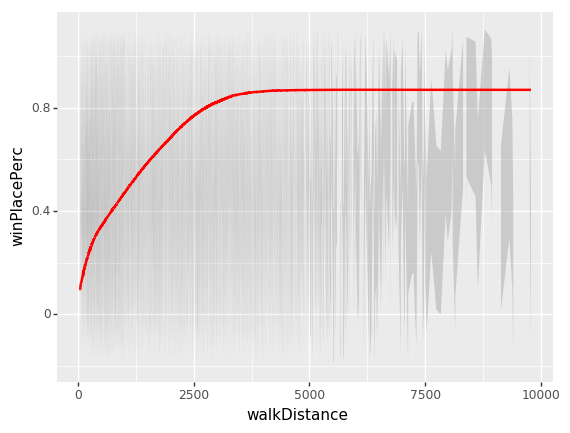

<ggplot: (8735633019014)>

In [59]:
# Plot the predictive quality of walkDistance
x_all = get_sample(train, 100000)
ggplot(x_all, aes('walkDistance','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

In [60]:
# Prepare data
val_perc_full = 0.12 # % to use for validation set
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc']) # all columns except target
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)

print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (3911403, 19) Sample target shape:  (3911403,) Sample validation shape:  (533373, 19)


In [61]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
m3 = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

['mae train: ', 0.031165288775746616, 'mae val: ', 0.056077806893848677]


In [62]:
# Add engineered features to the test set
test['headshot_rate'] = test['headshotKills'] / test['kills']
test['headshot_rate'] = test['headshot_rate'].fillna(0)
test['totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100 + 1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100 + 1)
test['maxPlaceNorm'] = test['maxPlace']*((100-train['playersJoined'])/100 + 1)
test['matchDurationNorm'] = test['matchDuration']*((100-test['playersJoined'])/100 + 1)
test['healsandboosts'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['totalDistance'] == 0))

# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

# Remove irrelevant features from the test set
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()

,walkDistance,killPlace,totalDistance,weaponsAcquired,healsandboosts,boosts,longestKill,heals,damageDealt,rideDistance,kills,matchDurationNorm,killsNorm,matchDuration,damageDealtNorm,maxPlaceNorm,numGroups,playersJoined,maxPlace
0,588.0,73,588.0,1,0,0,0.00,0,51.46,0.0,0,2034.72,0.00,1884,55.5768,29.12,28,92,28
1,2017.0,11,6686.0,6,6,4,361.90,2,179.10,4669.0,2,1883.44,2.08,1811,186.2640,52.32,47,96,48
2,787.8,49,787.8,4,4,0,0.00,4,23.40,0.0,0,1900.58,0.00,1793,24.8040,28.56,27,94,28
3,1812.0,54,1812.0,3,0,0,0.00,0,65.52,0.0,0,2035.74,0.00,1834,72.7272,49.05,44,89,45
4,2963.0,7,2963.0,4,5,4,60.06,1,330.20,0.0,3,1392.30,3.15,1326,346.7100,28.84,27,95,28


In [63]:
# Make submission ready for Kaggle
# We use our final Random Forest model (m3) to get the predictions
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})

# Create submission file
pred_df.to_csv("submission.csv", index=False)

In [64]:
# Last check of submission
print('Head of submission: ')
display(pred_df.head())
print('Tail of submission: ')
display(pred_df.tail())

Head of submission: 


,Id,winPlacePerc
0,9329eb41e215eb,0.219925
1,639bd0dcd7bda8,0.904428
2,63d5c8ef8dfe91,0.702298
3,cf5b81422591d1,0.536697
4,ee6a295187ba21,0.909783


Tail of submission: 


,Id,winPlacePerc
1934169,a316c3a13887d5,0.726110
1934170,5312146b27d875,0.412950
1934171,fc8818b5b32ad3,0.909798
1934172,a0f91e35f8458f,0.850136
1934173,3696fc9f3a42b2,0.044185
